# Conllu files exploration for Cleanup Memory insertion

The idea of this notebook is to explore the CONLLU files to extract the knowledge and be able to create compressed memories indexed with similarity search (or Locallity Sensitive Hashing).

The final goal is to be able to insert that knowledge directly inside a memory in a neural network such as the learning happens as a mapping from the input to the cleanup memory that can have new knowledge added from an external source directly in the memory leading to my idea of the NeuralDB

In [ ]:
from multiprocessing import Pool, cpu_count

import os, sys
import orjson as json
import pyconll
import pyconll.util

try:
    from utf8.utils import *
except:
    # to solve issue with ipython executing this import
    from utils import *

from preprocessors.preprocess_conllu import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
UD_VERSION = "2.5"
BASEPATH = "/home/leo/projects/Datasets/text"
CONLLU_BASEPATH = os.path.join(BASEPATH, 'UniversalDependencies/ud-treebanks-v{}'.format(UD_VERSION))

In [4]:
rootdir=CONLLU_BASEPATH
blacklist=BLACKLIST
allconll = get_all_files_recurse(rootdir)
train, test, dev = filter_conllu_files(allconll, blacklist)

In [5]:
len(test)

115

In [6]:
test_fr = [f for f in test if "French" in f]

In [7]:
test_fr

['/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-Spoken/fr_spoken-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-Sequoia/fr_sequoia-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-GSD/fr_gsd-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-PUD/fr_pud-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-ParTUT/fr_partut-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_French-FQB/fr_fqb-ud-test.conllu',
 '/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_Old_French-SRCMF/fro_srcmf-ud-test.conllu']

In [8]:
fname = test_fr[5]
conll = pyconll.load_from_file(fname)

In [9]:
sentences = [s for s in conll]

In [10]:
len(sentences)

2289

In [11]:
len(conll)

2289

In [12]:
[t.form for t in sentences[0]._tokens]

["Qu'", 'est', '-ce', "qu'", 'une', 'aide', 'au', 'à', 'le', 'logement', '?']

Now I'll analyze the sets of knowledge extracted from the conllu files, the idea is to try to compress all the knowledge and later be able to match the sentences with the right knowledge status.

One of the ways of doing this is having a key-value memory, where the key is looked at by similarity search and the output value is a weighted sum of the *top k* values

A simple analysis of the fields gives a first approach on what to add as knowledge

    conll_lemma.append([t.lemma for t in sen._tokens])  # this one doesn't work for multi-lang .. better for mono-lang, also needs really big dataset, this kind of knowledge can be obtained form a dictionary
    conll_upos.append([t.upos for t in sen._tokens]) #this one
    conll_xpos.append([t.xpos for t in sen._tokens]) #this one
    conll_feats.append([t.head for t in sen._tokens]) # difficult to do a first target memory, is a complex field 
    conll_head.append([t.deprel for t in sen._tokens]) #this one
    sen_form = [t.form for t in sen._tokens]  # difficult to do a first target memory, is a complex field
    sen_feats = [t.feats for t in sen._tokens]  # difficult to do a first target memory, is a complex field
    sen_deps = [t.deps for t in sen._tokens]  # TOO complex
    sen_misc = [t.mis for t in sen._tokens]  # TOO complex



In [13]:
# def _try_process_2list(fname):
#     try:
#         return conllu_separate_fields(fname)
#     except Exception as e:
#         print("Error processing file: {} \nWith error: {}".format(fname, e))


# def conllu_process_2list(rootdir=CONLLU_BASEPATH, blacklist=BLACKLIST):
#     allconll = get_all_files_recurse(rootdir)
#     train, test, dev = filter_conllu_files(allconll, blacklist)
#     all_files = train + test + dev
#     # print(all_files)

#     with Pool(processes=cpu_count()) as pool:
#         res = pool.map(_try_process_2list, all_files)
#         return res

In [14]:
# res = conllu_separate_fields(test_fr[0])

In [15]:
# res

In [16]:
# %%time
# res = conllu_process_2list()

In [17]:
# len(res)

In [18]:
# res = [r for r in res if r[0][1] > 0]

In [19]:
# len(res)

In [20]:

def conllu_get_fields(fname):
    """
    Processes one conllu file
    :param fname: absolute path to the conllu file
    :return:
    """
    conll = pyconll.load_from_file(fname)
    upos = []
    xpos = []
    deprel = []

    src_lang = path_leaf(fname).split('_')[0]
    for sen in conll:
        try:
            sen_upos = [t.upos for t in sen._tokens]
            upos.append((src_lang, sen.text, tuple(sen_upos)))
        except:
            pass
        try:
            sen_xpos = [t.xpos for t in sen._tokens]
            xpos.append((src_lang, sen.text, tuple(sen_xpos)))
        except:
            pass
        try:
            sen_deprel = [t.deprel for t in sen._tokens]
            deprel.append((src_lang, sen.text, tuple(sen_deprel)))
        except:
            pass
    
    return (set(upos), len(upos)), (set(xpos), len(xpos)), (set(deprel), len(deprel))


In [21]:
(upos, upos_count), (xpos, xpos_count), (deprel, deprel_count) = conllu_get_fields(test_fr[0])

In [22]:
len(upos), upos_count, len(xpos), xpos_count, len(deprel), deprel_count

(719, 726, 719, 726, 720, 726)

In [23]:

def _try_get_2list(fname):
    try:
        return conllu_get_fields(fname)
    except Exception as e:
        print("Error processing file: {} \nWith error: {}".format(fname, e))


def conllu_process_get_2list(rootdir=CONLLU_BASEPATH, blacklist=BLACKLIST):
    allconll = get_all_files_recurse(rootdir)
    train, test, dev = filter_conllu_files(allconll, blacklist)
    all_files = train + test + dev
    # print(all_files)

    with Pool(processes=cpu_count()) as pool:
        res = pool.map(_try_get_2list, all_files)
        return res


In [24]:
%%time
res = conllu_process_get_2list()

CPU times: user 7.54 s, sys: 1.49 s, total: 9.03 s
Wall time: 1min 28s


In [25]:
len(res), len(res[0])

(271, 3)

In [26]:
(upos, upos_count), (xpos, xpos_count), (deprel, deprel_count) = res[20]

In [27]:
# list(upos)[0]

In [28]:
len(upos), upos_count, len(xpos), xpos_count, len(deprel), deprel_count

(2195, 2231, 2195, 2231, 2195, 2231)

XPOS seems to be always None!!! :S -> check what happens there ... but for the moment I don  care as there are other things to see ...

Finding now the shortest and longest sequences, checking the length and plotting those to see what's happening with the dataset.

In [29]:
%%time

upos_data = []
xpos_data = []
deprel_data = []

for r in res:
    upos_val, xpos_val, deprel_val = r
#     print("lala 1")
    for val in upos_val[0]:
#         print(val)
        lang1, txt1, upos  = val
        upos_data.append((lang1, txt1, upos, len(upos)))
    for lang2, txt2, xpos in xpos_val[0]:
        xpos_data.append((lang2, txt2, xpos, len(xpos)))
    for lang3, txt3, deprel in deprel_val[0]:
        deprel_data.append((lang3, txt3, deprel, len(deprel)))

# upos_data = sorted(upos_data)
# xpos_data = sorted(xpos_data)
# deprel_data = sorted(deprel_data)

    

CPU times: user 900 ms, sys: 34.4 ms, total: 934 ms
Wall time: 933 ms


In [30]:
len(upos_data), len(xpos_data), len(deprel_data)

(1026878, 1027137, 1027198)

In [31]:
df_upos = pd.DataFrame(upos_data, columns=["lang", "text", "upos", "upos_len"])
df_xpos = pd.DataFrame(xpos_data, columns=["lang", "text", "xpos", "xpos_len"])
df_deprel = pd.DataFrame(deprel_data, columns=["lang", "text", "deprel", "deprel_len"])

In [32]:
df_upos.columns

Index(['lang', 'text', 'upos', 'upos_len'], dtype='object')

In [33]:
df_upos['lang'].describe

<bound method NDFrame.describe of 0          eu
1          eu
2          eu
3          eu
4          eu
           ..
1026873    nl
1026874    nl
1026875    nl
1026876    nl
1026877    nl
Name: lang, Length: 1026878, dtype: object>

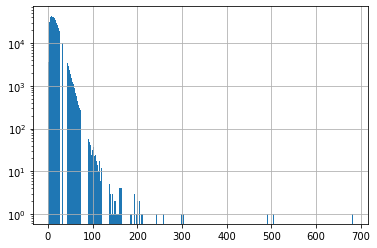

In [34]:
# fig, ax = plt.subplots()
# series.hist(ax=ax, bins=100, bottom=0.1)
# ax.set_yscale('log')
df_upos['upos_len'].hist(bins=1000, log=True)

First exploration seems to show a difference of sentence length by groups, which might be due to languages ... so I'll try to see what are the  issues and then I'll select languages and lengths accordingly



In [55]:
langs = df_upos['lang'].unique()

In [71]:
from pycountry import languages


/home/leo/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


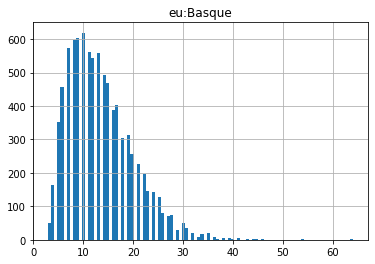

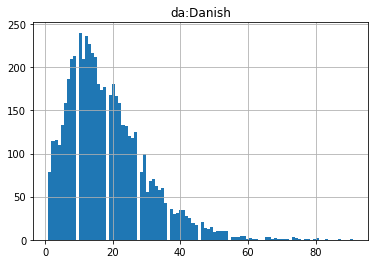

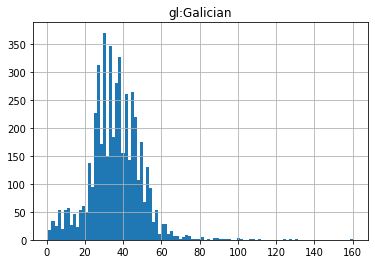

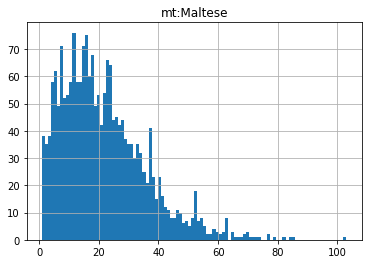

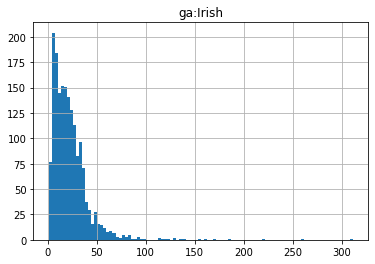

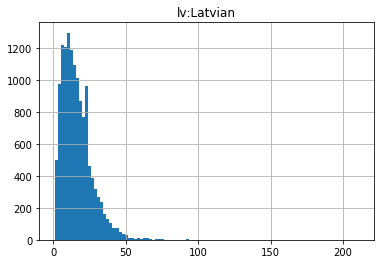

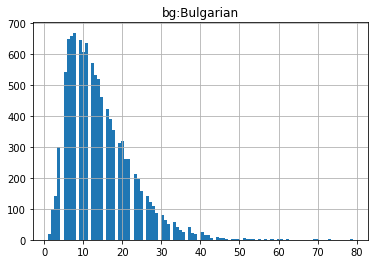

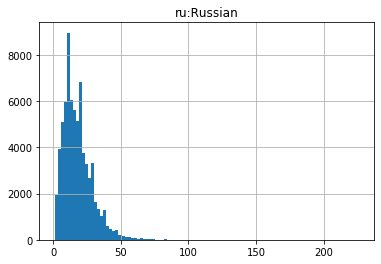

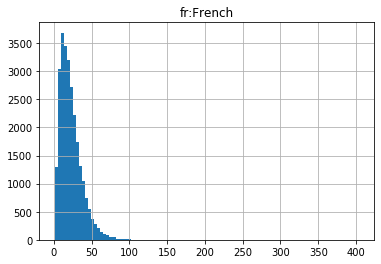

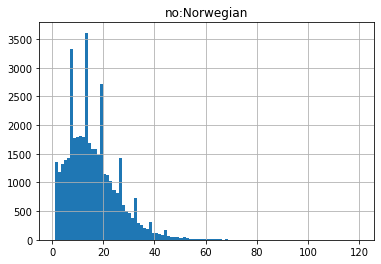

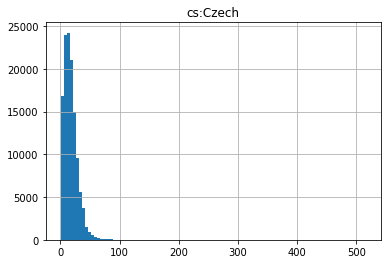

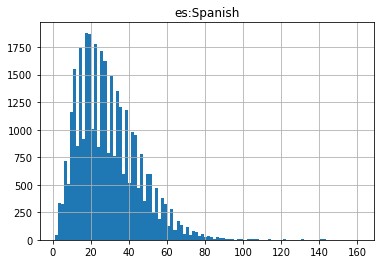

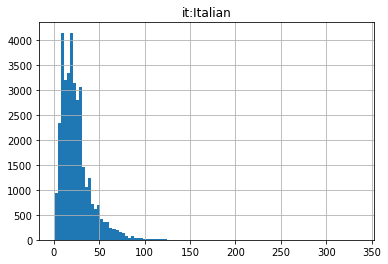

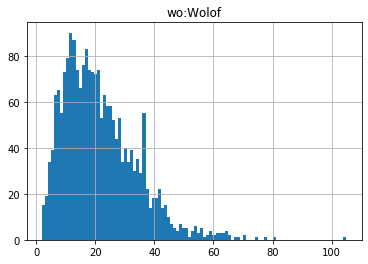

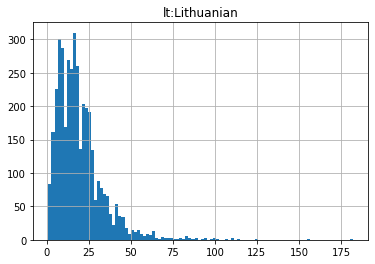

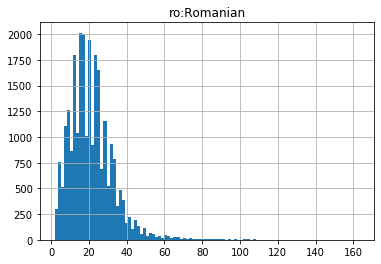

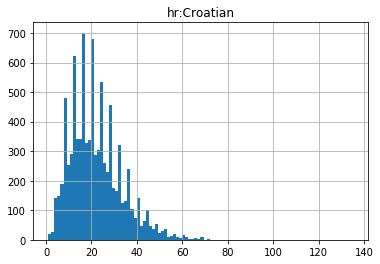

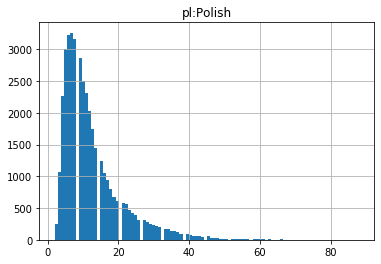

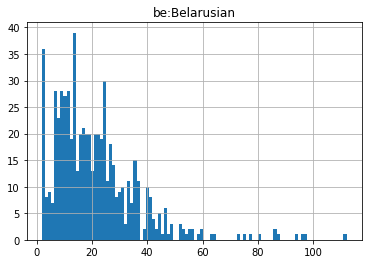

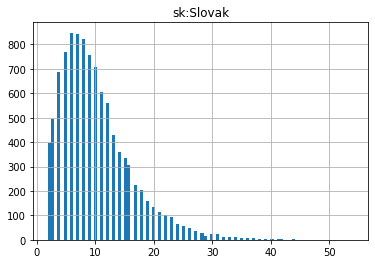

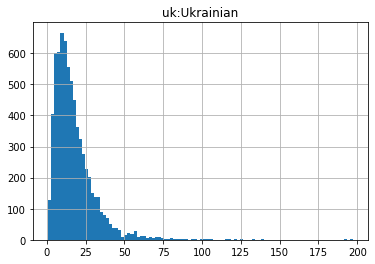

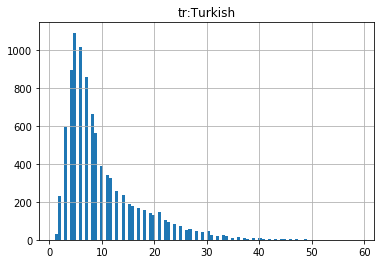

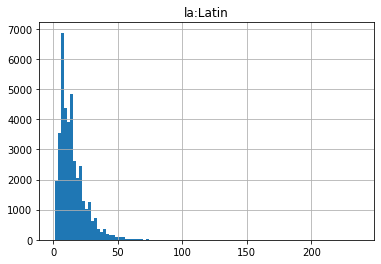

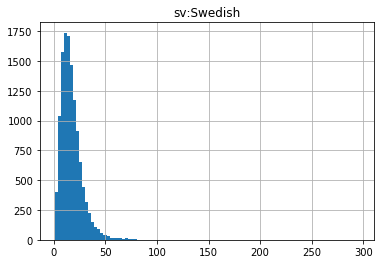

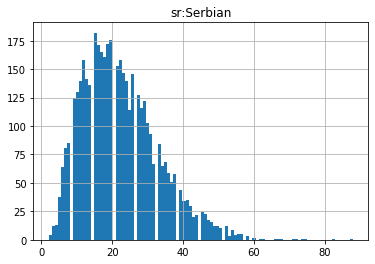

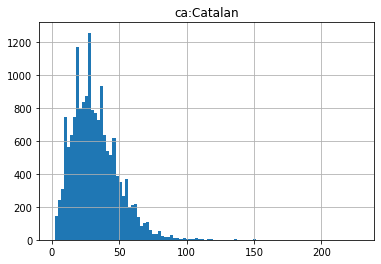

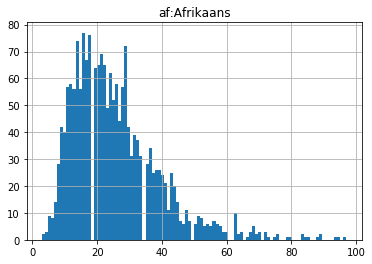

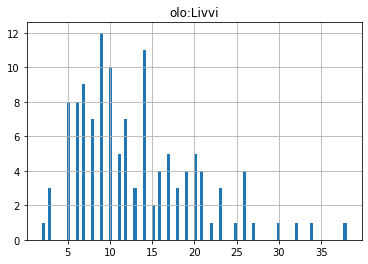

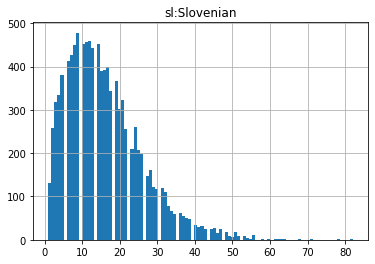

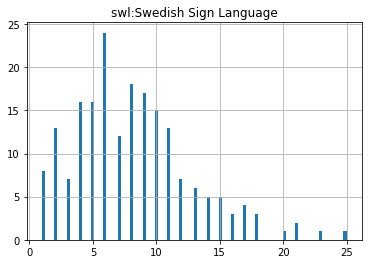

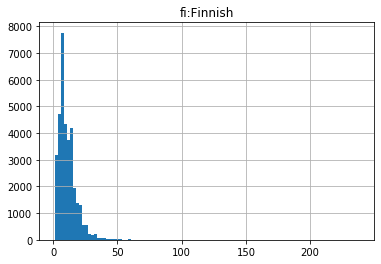

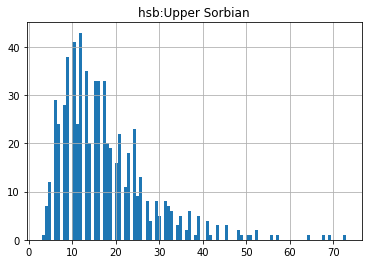

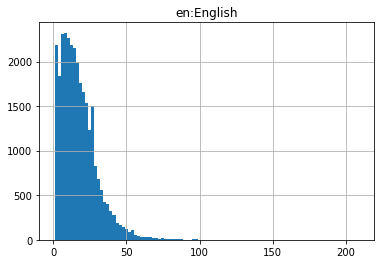

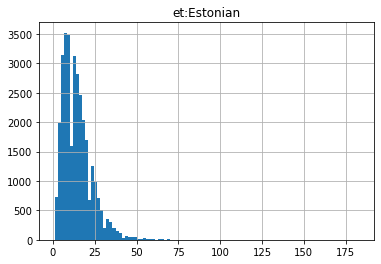

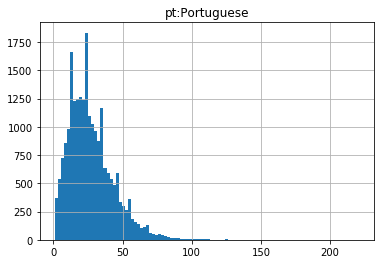

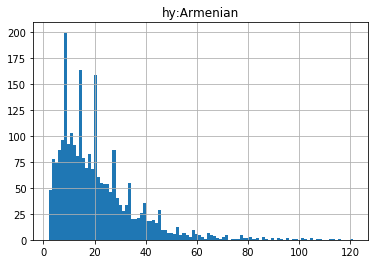

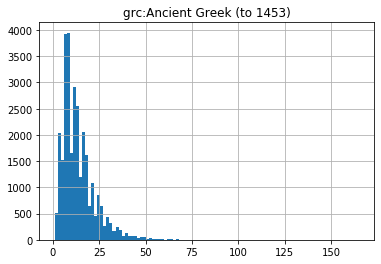

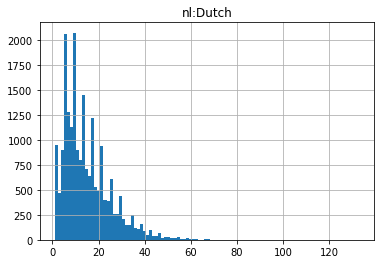

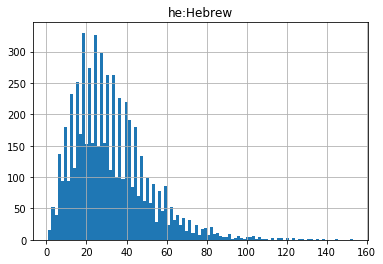

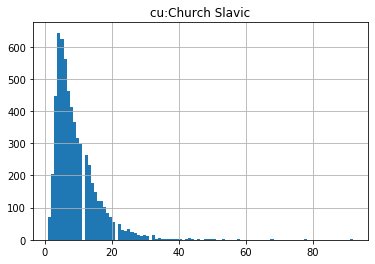

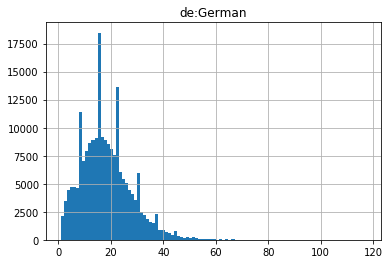

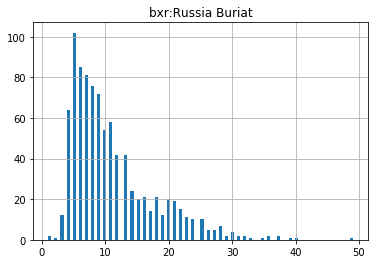

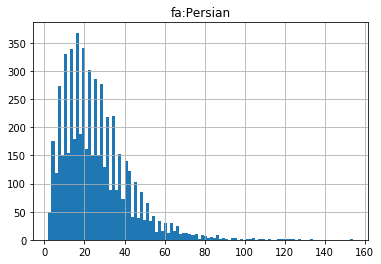

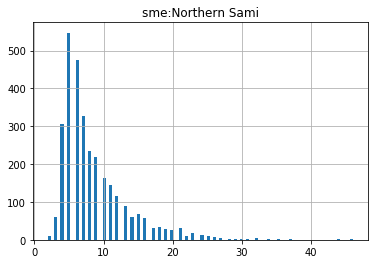

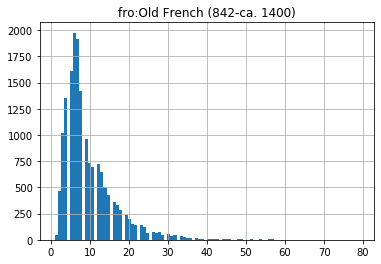

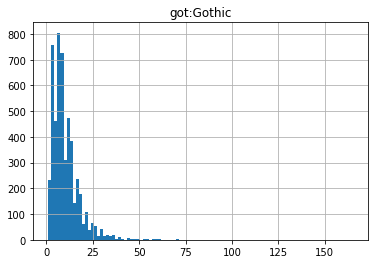

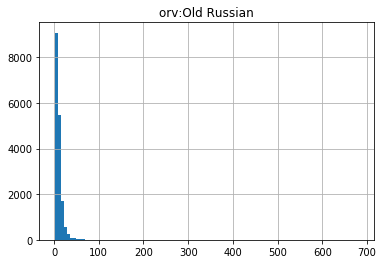

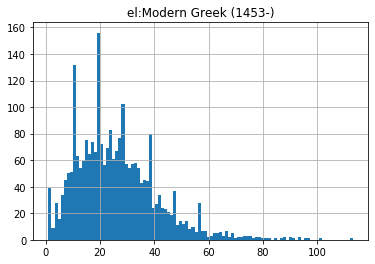

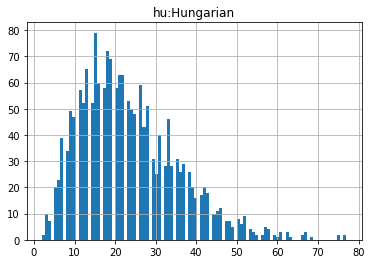

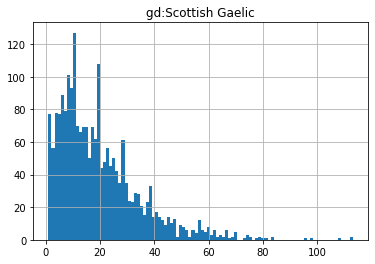

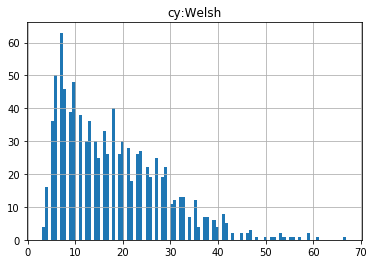

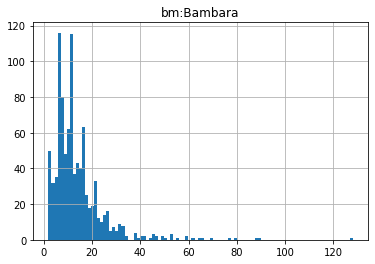

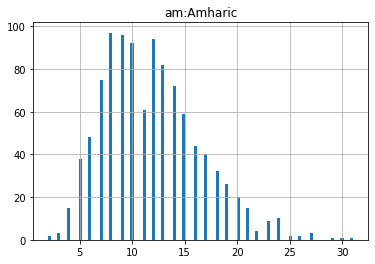

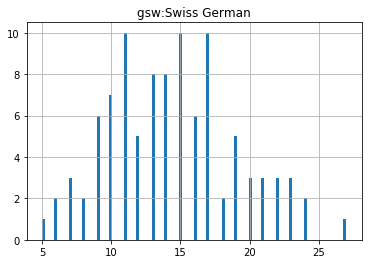

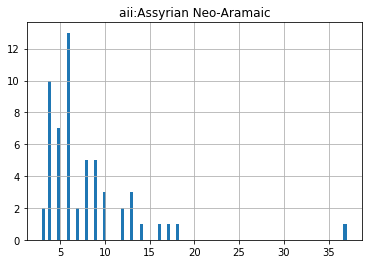

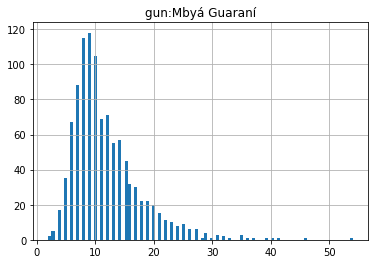

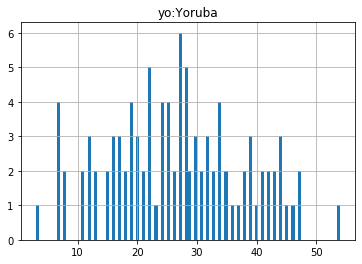

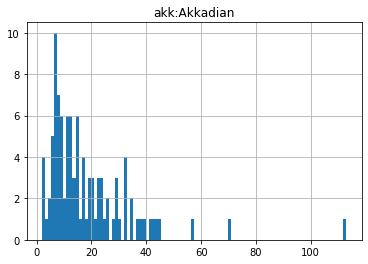

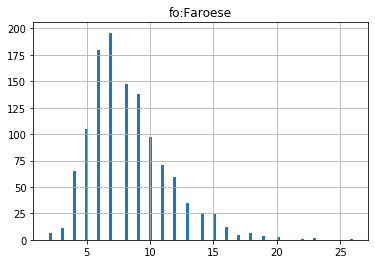

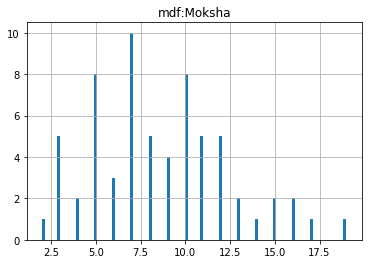

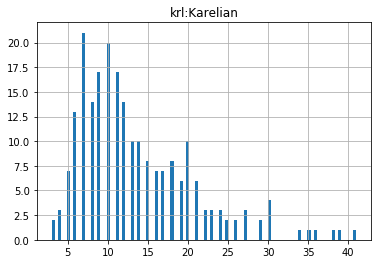

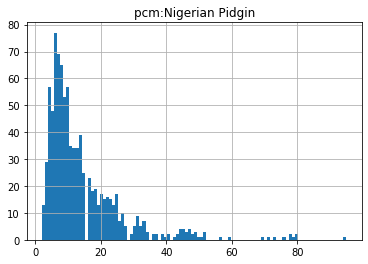

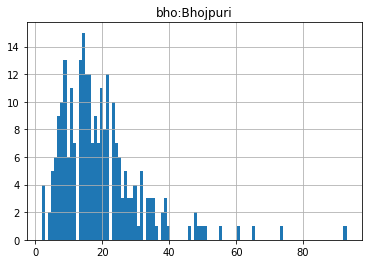

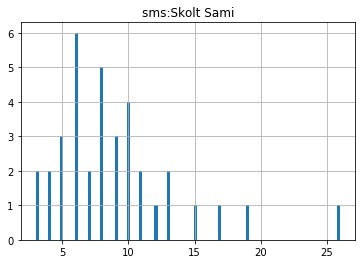

In [72]:
for lang in langs:
    fig, ax = plt.subplots()
    dest_lang = languages.get(alpha_2=lang) if len(lang) == 2 else languages.get(alpha_3=lang)
    dest_lang = dest_lang.name
    ax.set_title(lang +":" +dest_lang )
    df_upos.loc[df_upos['lang'] == lang]['upos_len'].hist(bins=100, ax=ax, label=lang)

In [69]:
langs

array(['eu', 'da', 'gl', 'mt', 'ga', 'lv', 'bg', 'ru', 'fr', 'no', 'cs',
       'es', 'it', 'wo', 'lt', 'ro', 'hr', 'pl', 'be', 'sk', 'uk', 'tr',
       'la', 'sv', 'sr', 'ca', 'af', 'olo', 'sl', 'swl', 'fi', 'hsb',
       'en', 'et', 'pt', 'hy', 'grc', 'nl', 'he', 'cu', 'de', 'bxr', 'fa',
       'sme', 'fro', 'got', 'orv', 'el', 'hu', 'gd', 'cy', 'bm', 'am',
       'gsw', 'aii', 'gun', 'yo', 'akk', 'fo', 'mdf', 'krl', 'pcm', 'bho',
       'sms'], dtype=object)

In [50]:
# @interact
# def show_len_by_lang(column='upos_len', x=10):
# #     return df_upos[df_upos[column == x]]  # ['upos_len'].hist(bins=100, log=True)
#     return df_upos.loc[df_upos[column] > x]

,lang,text,upos,upos_len
0,eu,Gaur egin diguten ongietorria eta han geundela...,"(ADV, VERB, AUX, NOUN, CCONJ, ADV, VERB, VERB,...",14
1,eu,"Haren osasuna aztertu dute, eta estupefaziente...","(DET, NOUN, VERB, AUX, PUNCT, CCONJ, NOUN, ADP...",15
3,eu,"Artzantzari utziz gero, erabat barreiatuta biz...","(NOUN, VERB, ADV, PUNCT, ADV, VERB, ADJ, AUX, ...",14
5,eu,"Oraingoz, behintzat, maitasuna da nagusi Athle...","(ADV, PUNCT, CCONJ, PUNCT, NOUN, AUX, ADJ, PRO...",14
6,eu,Amaren hilobian norbait zegoela ohartu nintzen...,"(NOUN, NOUN, PRON, VERB, VERB, AUX, PUNCT, CCO...",14
...,...,...,...,...
1026872,nl,",,Maar ik heb in elk geval twintig punten, daa...","(PUNCT, CCONJ, PRON, VERB, ADP, DET, NOUN, NUM...",29
1026873,nl,Ik ben nu zo ver dat ik weet dat ik van iedere...,"(PRON, AUX, ADV, ADV, ADJ, SCONJ, PRON, VERB, ...",16
1026874,nl,Mensen kunnen lachen en zeggen: waar heb je he...,"(NOUN, AUX, VERB, CCONJ, VERB, PUNCT, ADV, VER...",12
1026875,nl,"Als dan de tweede valt, is het heel moeilijk d...","(SCONJ, ADV, DET, ADJ, VERB, PUNCT, AUX, PRON,...",17


In [36]:
# train[0]

'/home/leo/projects/Datasets/text/UniversalDependencies/ud-treebanks-v2.5/UD_Basque-BDT/eu_bdt-ud-train.conllu'

In [37]:
# %%time

# all_upos = set([])
# all_upos_count = 0
# all_deprel = set([])
# all_deprel_count = 0

# for r in res:
#     (upos, upos_count), (xpos, xpos_count), (deprel, deprel_count) = r
#     all_upos = all_upos.union(upos)
#     all_upos_count += upos_count
#     all_deprel = all_deprel.union(deprel)
#     all_deprel_count += deprel_count
    



CPU times: user 14.1 s, sys: 2.28 s, total: 16.4 s
Wall time: 16.4 s


In [38]:
len(all_upos), all_upos_count, len(all_deprel), all_deprel_count

(1019311, 1045024, 1022037, 1045024)

It seems kind of big for putting it directly in a memory, some compression should be done if this method is to work ... (it should be more data efficient than the current methods)

For a single language that might be feasible, but as more languages are added this leads to a volume problem ... 

In [39]:
lall_upos = list(all_upos)
lup = [len(u) for u in lall_upos]

In [40]:
max(lup), min(lup)

(3, 3)

In [41]:
lup.index(max(lup)), lup.index(min(lup))

(0, 0)

In [42]:
lall_upos[83026]

('lv', 'Bet es arvien esmu.', ('CCONJ', 'PRON', 'ADV', 'VERB', 'PUNCT'))

In [43]:
lall_upos[371226]

('ru',
 'К сожалению, две запущенные в 1988 г. станции "Фобос" не смогли выполнить программу.',
 ('ADP',
  'NOUN',
  'PUNCT',
  'NUM',
  'VERB',
  'ADP',
  'NUM',
  'NOUN',
  'NOUN',
  'PUNCT',
  'PROPN',
  'PUNCT',
  'PART',
  'VERB',
  'VERB',
  'NOUN',
  'PUNCT'))

The issue here seems to be the length of the sentences, putting a max length might make it shorter